In [87]:
import numpy as np
import matplotlib.pylab as plt
import sklearn
from skimage import io
import tensorflow as tf
%matplotlib inline

from load_animals import *
from influence.iter_attack import get_projection_to_box_around_orig_point
from influence.inceptionModel import BinaryInceptionModel
from data_poisoning import data_poisoning

from utils import dataset_metadatas, experiment_result_metadata_to_FN, FN_to_experiment_result_metadata, get_dataset, render_img, get_full_model_graph

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
def analyze_results(indices_and_poisons_FNs, visualize=False, tsne=False, logits=False, cache={}):
    """
    cache would really save time in execution if provided
    cache["full_model_and_graph"] should give (full_model, full_graph)
    cache["data_sets"] should give (data_sets)
    """
    # Get metadata from file name
    FN_1, FN_2 = indices_and_poisons_FNs
    first_is_indices = FN_to_experiment_result_metadata(FN_1)["contents_type"] == "indices"
    if first_is_indices:
        indices_FN = FN_1
        poisons_FN = FN_2
    else:
        indices_FN = FN_2
        poisons_FN = FN_1
    
    # Get dataset metadata and load dataset
    dataset_name = FN_to_experiment_result_metadata(indices_FN)["dataset_name"]
    dataset_metadata = dataset_metadatas[dataset_name]
    
    # Constants that don't change for Inception (May need to change for other feature extraction methods like Resnet)
    img_side = 299
    num_channels = 3
    
    # Variables used throughout the analysis
    training_dataset_classes = dataset_metadata["classes"]
    num_train_ex_per_class = dataset_metadata["num_train_ex_per_class"]
    num_test_ex_per_class = dataset_metadata["num_test_ex_per_class"]
    num_classes = len(training_dataset_classes)
    num_training_points = num_train_ex_per_class * num_classes
    num_testing_points = num_test_ex_per_class * num_classes
    poisoned_training_points = np.load(poisons_FN)
    poisoned_training_points_indices = np.load(indices_FN)
    target_test_points_indices = [FN_to_experiment_result_metadata(indices_FN)["test_idx"]] # Currently the file name has one test index, need to extend to file names with multiple test indices
    num_target_test_points = len(target_test_points_indices)
    num_poisoned_training_points = len(poisoned_training_points_indices)
    method = FN_to_experiment_result_metadata(indices_FN)["method"]
    
    # load dataset if they're not in the cache
    if cache["data_sets"]:
        data_sets = cache["data_sets"]
    else:
        data_sets = get_dataset(dataset_metadata)

    if visualize:
        # render original training points and poisoned ones
        screen_width = 12.5
        plt.figure(figsize=(screen_width, screen_width/num_poisoned_training_points * 2))
        for i, index_to_poison in enumerate(poisoned_training_points_indices):
            plt.subplot(2,num_poisoned_training_points,i+1)
            plt.title("Original Training Image [{}]".format(index_to_poison))
            render_img(data_sets.train.x[index_to_poison].reshape((img_side,img_side,num_channels)))

        for i, (training_point, index_to_poison) in enumerate(zip(poisoned_training_points, poisoned_training_points_indices)):
            plt.subplot(2,num_poisoned_training_points,num_poisoned_training_points+i+1)
            plt.title("Poisoned Training Image [{}]".format(index_to_poison))
            render_img(training_point.reshape((img_side,img_side,num_channels)))

        # render target test images
        plt.figure(figsize=(screen_width,screen_width/num_target_test_points))
        for target_index in target_test_points_indices:
            plt.subplot(2,num_poisoned_training_points,i+1)
            plt.title("Target test image [{}]".format(target_index))
            render_img(data_sets.test.x[target_index].reshape((img_side,img_side,num_channels)))
        plt.show()
    
    if not tsne and not logits:
        return
    
    print("Setting up full model...")
    # load full model if it's not in the cache argument
    if cache["full_model_and_graph"]:
        full_graph, full_model = cache["full_model_and_graph"]
    else:
        full_graph, full_model = get_full_model_graph(dataset_metadata, data_sets)
    
    if tsne:
        all_dataset_x = np.concatenate([np.copy(data_sets.train.x), 
                                        poisoned_training_points, 
                                        poisoned_training_points_clipped if method == "FC" else [], 
                                        data_sets.test.x[target_test_points_indices]
                                       ], axis = 0)
        all_dataset_labels = np.concatenate([np.copy(data_sets.train.labels),  
                                             np.copy(data_sets.train.labels[poisoned_training_points_indices]), 
                                             np.copy(data_sets.train.labels[poisoned_training_points_indices]) if method == "FC" else [],
                                             data_sets.test.labels[target_test_points_indices]], axis = 0)
        all_dataset = DataSet(all_dataset_x, all_dataset_labels)
        print "Extracting latent space features..."
        with full_graph.as_default():
            all_inceptions = full_model.generate_inception_features(all_dataset, None)
    
        # Calculate tSNE
        from sklearn.manifold import TSNE
        print "Calculating tSNE..."
        tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=69)
        tsne_results = tsne.fit_transform(all_inceptions)

        plt.figure(figsize=(12,12))
        # plot entire training dataset
        for class_label in range(num_classes):
            class_mask = data_sets.train.labels == class_label
            plt.scatter(tsne_results.T[0][:num_training_points][class_mask], 
                        tsne_results.T[1][:num_training_points][class_mask], 
                        label=training_dataset_classes[class_label]) 

        # plot training points before poison
        plt.scatter(tsne_results.T[0][poisoned_training_points_indices], 
                    tsne_results.T[1][poisoned_training_points_indices], 
                    label="Original Training Points", marker='*', s=200)
        for index, coordinate in zip(poisoned_training_points_indices, tsne_results[poisoned_training_points_indices]):
            plt.annotate(s=str(index), xy = coordinate)
        # plot training points after poison no clipping
        plt.scatter(tsne_results.T[0][num_training_points:num_training_points+num_poisoned_training_points], 
                    tsne_results.T[1][num_training_points:num_training_points+num_poisoned_training_points], 
                    label="Non-rescaled poisoned training point", marker='*', s=200)
        for index, coordinate in zip(poisoned_training_points_indices, tsne_results[num_training_points:num_training_points+num_poisoned_training_points]):
            plt.annotate(s=str(index), xy = coordinate)
        # plot training points after poison with clipping (if applicable)
        if method == "FC":
            plt.scatter(tsne_results.T[0][-num_target_test_points-num_poisoned_training_points:-num_target_test_points], 
                        tsne_results.T[1][-num_target_test_points-num_poisoned_training_points:-num_target_test_points], 
                        label="Rescaled poisoned training point", marker='*', s=200)
            for index, coordinate in zip(poisoned_training_points_indices, tsne_results[-num_target_test_points-num_poisoned_training_points:-num_target_test_points]):
                plt.annotate(s=str(index), xy = coordinate)
        # plot target test points
        plt.scatter( tsne_results.T[0][-num_target_test_points:], tsne_results.T[1][-num_target_test_points:], label="Target test points", marker='*', s=200)
        for index, coordinate in zip(target_test_points_indices, tsne_results[-num_target_test_points:]):
            plt.annotate(s=str(index), xy = coordinate)

        plt.legend()
        plt.show()
    
    if logits:
        print "Training on clean dataset..."
        with full_graph.as_default():
            clean_w = full_model.retrain_and_get_weights(data_sets.train.x, data_sets.train.labels)

        clean_total_test_logits = full_model.get_preds(data_sets.test, np.arange(len(data_sets.test.x)))
        clean_total_test_acc = np.sum(np.argmax(clean_total_test_logits, axis=1) == data_sets.test.labels) / float(num_testing_points)
        clean_test_logits = full_model.get_preds(data_sets.test, target_test_points_indices) # target_test_img_indices should be a list

        poisoned_data_set_x = np.copy(data_sets.train.x)
        poisoned_data_set_x[poisoned_training_points_indices] = poisoned_training_points
        poisoned_data_set_labels = np.copy(data_sets.train.labels)

        print "Training on poisoned dataset..."
        with full_graph.as_default():
            poisoned_w = full_model.retrain_and_get_weights(poisoned_data_set_x, poisoned_data_set_labels)

        poisoned_total_test_logits = full_model.get_preds(data_sets.test, np.arange(len(data_sets.test.x)))
        poisoned_total_test_acc = np.sum(np.argmax(poisoned_total_test_logits, axis=1) == data_sets.test.labels) / float(num_testing_points)
        poisoned_test_logits = full_model.get_preds(data_sets.test, target_test_points_indices) # target_test_img_indices should be a list

        angle = np.inner(clean_w, poisoned_w)/np.square(np.linalg.norm(clean_w))/np.square(np.linalg.norm(clean_w))
        
        return (clean_total_test_acc, poisoned_total_test_acc), (clean_test_logits, poisoned_test_logits), angle, (clean_w, poisoned_w)

In [99]:
file_names = !ls -rt Experiment_results/Experiment_1/Eagle-Mushroom/FC/
file_names

['Experiment_1_poisons_FC_Eagle-Mushroom_num_train_1__12.npy',
 'Experiment_1_indices_FC_Eagle-Mushroom_num_train_1__12.npy',
 'Experiment_1_poisons_FC_Eagle-Mushroom_num_train_1__80.npy',
 'Experiment_1_indices_FC_Eagle-Mushroom_num_train_1__80.npy',
 'Experiment_1_poisons_FC_Eagle-Mushroom_num_train_1__33.npy',
 'Experiment_1_indices_FC_Eagle-Mushroom_num_train_1__33.npy',
 'Experiment_1_poisons_FC_Eagle-Mushroom_num_train_1__5.npy',
 'Experiment_1_indices_FC_Eagle-Mushroom_num_train_1__5.npy',
 'Experiment_1_poisons_FC_Eagle-Mushroom_num_train_1__28.npy',
 'Experiment_1_indices_FC_Eagle-Mushroom_num_train_1__28.npy',
 'Experiment_1_poisons_FC_Eagle-Mushroom_num_train_1__83.npy',
 'Experiment_1_indices_FC_Eagle-Mushroom_num_train_1__83.npy',
 'Experiment_1_poisons_FC_Eagle-Mushroom_num_train_1__69.npy',
 'Experiment_1_indices_FC_Eagle-Mushroom_num_train_1__69.npy',
 'Experiment_1_poisons_FC_Eagle-Mushroom_num_train_2__12.npy',
 'Experiment_1_indices_FC_Eagle-Mushroom_num_train_2__12.

In [100]:
source_dir = "Experiment_results/Experiment_1/Eagle-Mushroom/FC/"
indices_poisons_pairs = []
for i in range(0,len(file_names),2):
    indices_poisons_pairs.append((source_dir+file_names[i], source_dir+file_names[i+1]))
indices_poisons_pairs = indices_poisons_pairs[:21]
indices_poisons_pairs

[('Experiment_results/Experiment_1/Eagle-Mushroom/FC/Experiment_1_poisons_FC_Eagle-Mushroom_num_train_1__12.npy',
  'Experiment_results/Experiment_1/Eagle-Mushroom/FC/Experiment_1_indices_FC_Eagle-Mushroom_num_train_1__12.npy'),
 ('Experiment_results/Experiment_1/Eagle-Mushroom/FC/Experiment_1_poisons_FC_Eagle-Mushroom_num_train_1__80.npy',
  'Experiment_results/Experiment_1/Eagle-Mushroom/FC/Experiment_1_indices_FC_Eagle-Mushroom_num_train_1__80.npy'),
 ('Experiment_results/Experiment_1/Eagle-Mushroom/FC/Experiment_1_poisons_FC_Eagle-Mushroom_num_train_1__33.npy',
  'Experiment_results/Experiment_1/Eagle-Mushroom/FC/Experiment_1_indices_FC_Eagle-Mushroom_num_train_1__33.npy'),
 ('Experiment_results/Experiment_1/Eagle-Mushroom/FC/Experiment_1_poisons_FC_Eagle-Mushroom_num_train_1__5.npy',
  'Experiment_results/Experiment_1/Eagle-Mushroom/FC/Experiment_1_indices_FC_Eagle-Mushroom_num_train_1__5.npy'),
 ('Experiment_results/Experiment_1/Eagle-Mushroom/FC/Experiment_1_poisons_FC_Eagle-Mus

In [101]:
cache = {}
dataset_metadata = dataset_metadatas["Eagle-Mushroom"]
data_sets = get_dataset(dataset_metadata)
cache["data_sets"] = data_sets
cache["full_model_and_graph"] = get_full_model_graph(dataset_metadata, data_sets)

Loading animals from disk...
../data/dataset_Eagle-Mushroom_train-500_test-50.npz
self.logits Tensor("Shape:0", shape=(2,), dtype=int32)


[genericNeuralNet.py:191 -   get_vec_to_list_fn() ] Total number of parameters: 2048


wrong_labels_bool Tensor("Shape_2:0", shape=(2,), dtype=int32)
logits Tensor("Shape_3:0", shape=(2,), dtype=int32)
inception_features:  Tensor("flatten/Reshape:0", shape=(?, ?), dtype=float32)
x_poison_features:  Tensor("StridedSlice:0", dtype=float32)
t_target_features:  Tensor("Gather:0", shape=(1, ?), dtype=float32)
Lp:  Tensor("Mean_1:0", dtype=float32)
LP_gradient Tensor("strided_slice_1:0", shape=(?, 268203), dtype=float32)


In [102]:
for pair in indices_poisons_pairs:
    result = analyze_results(pair, logits=True, cache = cache)
    results[pair] = result

Setting up full model...
Training on clean dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00169404]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00039346]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.00038176789530552924]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 8.561374e-08
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 1.6128079


Training on poisoned dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00334949]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00100723]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.0014684819616377354]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 0.0081905825
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 2.1643767


Setting up full model...
Training on clean dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00169404]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00039346]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.0003817572141997516]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 7.9692754e-08
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 1.6128104


Training on poisoned dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00304131]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00095917]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.0007689938647672534]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 0.00858262
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 2.0406532


Setting up full model...
Training on clean dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00169404]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00039346]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.00038176789530552924]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 4.1340797e-08
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 1.6128081


Training on poisoned dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00334362]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00083353]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.0009311124449595809]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 0.005875114
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 2.2405798


Setting up full model...
Training on clean dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00169404]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00039344]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.0003817417600657791]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 1.7769614e-07
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 1.6128209


Training on poisoned dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00327416]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00096696]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.000735599547624588]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 0.007868857
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 2.1481142


Setting up full model...
Training on clean dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00169404]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00039345]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.00038175363442860544]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 1.5773958e-07
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 1.6128175


Training on poisoned dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00283882]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00089676]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.0006991315167397261]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 0.007866878
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 1.9708148


Setting up full model...
Training on clean dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00169404]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00039346]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.00038177266833372414]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 7.850767e-08
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 1.6128073


Training on poisoned dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00322747]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00091955]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.0009160733316093683]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 0.007104969
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 2.1484516


Setting up full model...
Training on clean dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00169404]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00039347]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.0003817714750766754]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 5.031387e-08
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 1.6128063


Training on poisoned dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00332555]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00078858]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.0007260760175995529]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 0.0053218906
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 2.25254


Setting up full model...
Training on clean dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00169404]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00039346]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.00038176673115231097]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 7.515026e-08
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 1.6128062


Training on poisoned dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.0040505]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00124881]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.0016453787684440613]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 0.011318053
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 2.3671474


Setting up full model...
Training on clean dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00169404]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00039346]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.00038176437374204397]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 5.8832075e-08
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 1.6128095


Training on poisoned dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00345474]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00116013]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.0007580601959489286]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 0.011158559
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 2.142243


Setting up full model...
Training on clean dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00169404]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00039346]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.00038176553789526224]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 4.5239403e-08
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 1.612809


Training on poisoned dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00371984]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00088701]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.0010579859372228384]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 0.006731936
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 2.3802633


Setting up full model...
Training on clean dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00169404]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00039346]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.00038177266833372414]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 5.596902e-08
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 1.6128091


Training on poisoned dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.0037226]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00100137]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.0008060243562795222]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 0.008900408
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 2.3329103


Setting up full model...
Training on clean dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00169404]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00039346]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.00038176908856257796]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 6.364495e-08
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 1.6128082


Training on poisoned dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00327967]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00105897]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.0008415456395596266]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 0.00987839
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 2.1074646


Setting up full model...
Training on clean dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00169404]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00039347]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.00038177502574399114]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 1.3122308e-07
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 1.6128049


Training on poisoned dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00392117]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00125012]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.0008352899458259344]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 0.010679874
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 2.311298


Setting up full model...
Training on clean dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00169404]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00039346]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.00038176789530552924]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 9.937435e-08
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 1.6128112


Training on poisoned dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00362194]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.0008286]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.0008111313218250871]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 0.00590172
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 2.3636158


Setting up full model...
Training on clean dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00169404]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00039346]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.00038177386159077287]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 3.065512e-07
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 1.6128061


Training on poisoned dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00496261]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00173388]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.0029822969809174538]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 0.016339397
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 2.541155


Setting up full model...
Training on clean dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00169404]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00039346]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.0003817691176664084]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 1.9443868e-07
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 1.6128073


Training on poisoned dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00411216]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00161927]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.000812684535048902]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [0.999]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 0.015343656
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 2.2328877


Setting up full model...
Training on clean dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00169404]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00039346]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.00038176789530552924]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 1.1942839e-07
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 1.6128097


Training on poisoned dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00414907]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00095464]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.0011756760068237782]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 0.0076695844
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 2.527617


Setting up full model...
Training on clean dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00169404]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00039346]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.00038176908856257796]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 7.653119e-08
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 1.6128097


Training on poisoned dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00462233]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00147905]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.0009336668881587684]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 0.013754109
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 2.5073006


Setting up full model...
Training on clean dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00169404]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00039348]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.0003817953111138195]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 4.433465e-07
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 1.6127974


Training on poisoned dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.0036179]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00124608]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.0008323898073285818]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 0.012035663
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 2.1779892


Setting up full model...
Training on clean dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00169404]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00039346]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.00038176431553438306]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 1.5451636e-07
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 1.6128107


Training on poisoned dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00457243]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00162357]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.0012568372767418623]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [0.999]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 0.0138452025
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 2.4285262


Setting up full model...
Training on clean dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00169404]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00039346]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.0003817691176664084]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 5.6451658e-08
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 1.6128092


Training on poisoned dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00400454]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00088951]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.0008383415406569839]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 0.00665965
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 2.4960072


In [104]:
len(results.keys())

56

In [108]:
Eagle_fish_results = {}
for k in results.keys():
    FN_1, FN_2 = k
    metadata = FN_to_experiment_result_metadata(FN_1)
    if metadata['dataset_name'] == 'Eagle-Mushroom':
        Eagle_fish_results[k] = results[k]

In [110]:
Eagle_fish_results.keys()

[('Experiment_results/Experiment_1/Eagle-Mushroom/FC/Experiment_1_poisons_FC_Eagle-Mushroom_num_train_1__5.npy',
  'Experiment_results/Experiment_1/Eagle-Mushroom/FC/Experiment_1_indices_FC_Eagle-Mushroom_num_train_1__5.npy'),
 ('Experiment_results/Experiment_1/Eagle-Mushroom/FC/Experiment_1_poisons_FC_Eagle-Mushroom_num_train_1__83.npy',
  'Experiment_results/Experiment_1/Eagle-Mushroom/FC/Experiment_1_indices_FC_Eagle-Mushroom_num_train_1__83.npy'),
 ('Experiment_results/Experiment_1/Eagle-Mushroom/FC/Experiment_1_poisons_FC_Eagle-Mushroom_num_train_1__28.npy',
  'Experiment_results/Experiment_1/Eagle-Mushroom/FC/Experiment_1_indices_FC_Eagle-Mushroom_num_train_1__28.npy'),
 ('Experiment_results/Experiment_1/Eagle-Mushroom/FC/Experiment_1_poisons_FC_Eagle-Mushroom_num_train_2__69.npy',
  'Experiment_results/Experiment_1/Eagle-Mushroom/FC/Experiment_1_indices_FC_Eagle-Mushroom_num_train_2__69.npy'),
 ('Experiment_results/Experiment_1/Eagle-Mushroom/FC/Experiment_1_poisons_FC_Eagle-Mus

In [111]:
for k,v in Eagle_fish_results.iteritems():
    FN_1, FN_2 = k
    (acc_c, acc_p), (logits_c, logits_p), angle, (w_c, w_p) = v
    starter = FN_1.split('.')[0]
    np.save(starter+'____'+"acc_angle_result", [acc_c, acc_p, angle])
    np.save(starter+'____'+"logitsClean_result", logits_c)
    np.save(starter+'____'+"logitsPoisoned_result", logits_p)
    np.save(starter+'____'+"wClean_result", w_c)
    np.save(starter+'____'+"wPoisoned_result", w_p)

In [84]:
"asdasd___asdd____".split('____')

['asdasd___asdd', '']

In [120]:
Dog_fish_IF_analysis_FNs = !ls -rt Experiment_results/Experiment_1/Dog-Fish/IF/Analaysis/
Dog_fish_IF_analysis_FNs = Dog_fish_IF_analysis_FNs[1:]
Dog_fish_IF_analysis_FNs[-5:]

['Experiment_1_indices_IF_Dog-Fish_num_train_4__416____wPoisoned_result.npy',
 'Experiment_1_indices_IF_Dog-Fish_num_train_4__416____wClean_result.npy',
 'Experiment_1_indices_IF_Dog-Fish_num_train_4__416____logitsPoisoned_result.npy',
 'Experiment_1_indices_IF_Dog-Fish_num_train_4__416____logitsClean_result.npy',
 'Experiment_1_indices_IF_Dog-Fish_num_train_4__416____acc_angle_result.npy']

In [153]:
dog_fish_dataset = get_dataset(dataset_metadatas["Dog-Fish"])

Loading animals from disk...
../data/dataset_dog-fish_train-900_test-300.npz


In [156]:
dog_fish_IF_extracted = []
for i in range(0,len(Dog_fish_IF_analysis_FNs),5):
    Dog_fish_IF_analysis_FNs[i]#wPosioned
    Dog_fish_IF_analysis_FNs[i+1]#wClean
    logitsPoisoned = np.load("Experiment_results/Experiment_1/Dog-Fish/IF/Analaysis/"+Dog_fish_IF_analysis_FNs[i+2])
    logitsClean = np.load("Experiment_results/Experiment_1/Dog-Fish/IF/Analaysis/"+Dog_fish_IF_analysis_FNs[i+3])
#     clean_labels = np.argmax(logitsClean, axis = 1)
    print Dog_fish_IF_analysis_FNs[i].split('_')
    print logitsClean
    clean_labels = dog_fish_dataset.test.labels[int(Dog_fish_IF_analysis_FNs[i].split('_')[9])]
    num_points = len(logitsPoisoned)
    final_orig_label_logits = logitsPoisoned[np.arange(num_points), clean_labels]
    acc_clean, acc_poisoned, angle = np.load("Experiment_results/Experiment_1/Dog-Fish/IF/Analaysis/" + Dog_fish_IF_analysis_FNs[i+4])
    num_poisoned = int(Dog_fish_IF_analysis_FNs[i].split('_')[7])
    dog_fish_IF_extracted.append((num_poisoned, acc_clean, acc_poisoned, angle, final_orig_label_logits))

['Experiment', '1', 'poisons', 'IF', 'Dog-Fish', 'num', 'train', '1', '', '278', '', '', '', 'wPoisoned', 'result.npy']
[[8.118543e-05 9.999188e-01]]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [149]:
dog_fish_IF_extracted_logits = np.asarray(dog_fish_IF_extracted)[:,[0,-1]]
DF_IF_logits_1 = dog_fish_IF_extracted_logits[dog_fish_IF_extracted_logits[:,0] == 1][:,1]
DF_IF_logits_2 = dog_fish_IF_extracted_logits[dog_fish_IF_extracted_logits[:,0] == 2][:,1]
DF_IF_logits_4 = dog_fish_IF_extracted_logits[dog_fish_IF_extracted_logits[:,0] == 4][:,1]
DF_IF_logits_8 = dog_fish_IF_extracted_logits[dog_fish_IF_extracted_logits[:,0] == 8][:,1]
DF_IF_logits_16 = dog_fish_IF_extracted_logits[dog_fish_IF_extracted_logits[:,0] == 16][:,1]

In [151]:
DF_IF_logits_4

array([1.00665948e-05, 1.02665092e-06, 1.08867453e-05, 1.01204167e-09,
       2.35358834e-06, 1.94600011e-06, 3.68017140e-07])

In [152]:
DF_IF_logits_8

array([1.29588265e-14, 5.46456000e-16, 4.11480095e-12, 1.00000000e+00,
       1.42357507e-13, 1.18465925e-06, 1.09754853e-14])

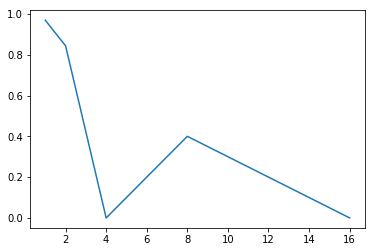

In [150]:
plt.plot([1,2,4,8,16], [np.percentile(logits, 90) for logits in [DF_IF_logits_1, DF_IF_logits_2, DF_IF_logits_4, DF_IF_logits_8, DF_IF_logits_16]])